In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/Users/purzelrakete/src/github.com/feldberlin/wavenet


In [2]:
import os


from celluloid import Camera
import numpy as np
import torch
import librosa
from torch.nn import functional as F
import torch.cuda.amp as amp
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
from IPython.core.display import HTML

import wandb

from wavenet import model, train, sample, audio, datasets, utils, viz

# What do the conditional distributions look like

Let's take a look at the tiny distributions.

In [6]:
n_samples, n_examples = 30, 5_000
p = model.HParams(
    mixed_precision=False,
    embed_inputs=False,
    n_audio_chans=1, 
    n_classes=2*n_samples, 
    n_chans=32,
    dilation_stacks=1,
    n_layers=6,
    compress=False, 
    sample_length=n_samples,
    seed=131,
    verbose=False
)

ds = datasets.Tiny(n_samples, n_examples)

m = model.Wavenet(p)
tp =  train.HParams(
    max_epochs=10, 
    batch_size=64, 
    num_workers=1, 
    learning_rate=0.01
)

os.environ['WANDB_MODE'] = 'disabled'
t = train.Trainer(m, ds, None, tp)

In [7]:
t.train()

10:78 loss 0.46175 lr 1.206838e-07: 100%|██████████| 79/79 [00:07<00:00, 10.23it/s]


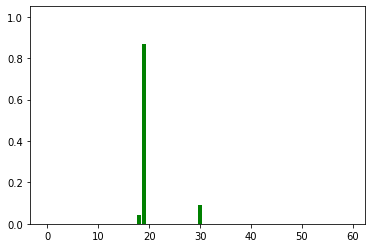

In [8]:
y, logits, *_ = sample.fast(m, ds.transforms, utils.decode_random, n_samples=30, batch_size=10)
posterior = F.softmax(logits, dim=1).cpu().numpy()

fig = plt.figure()
camera = Camera(fig)
for i in range(n_samples):
    plt.bar(list(range(n_samples * 2)), posterior[0, :, 0, i], color='green')
    camera.snap()

HTML(camera.animate().to_html5_video())